In [7]:
# Data handling
import pandas as pd
import numpy as np

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Visualization
import matplotlib.pyplot as plt


In [8]:
# Load the dataset
df = pd.read_csv("cleaned_reviews.csv")

# Quick check
print(df.shape)
print(df.head(4))


(5000, 3)
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   

                                      cleaned_review sentiment  
0  one of the other reviewers has mentioned that ...  positive  
1  a wonderful little production the filming tech...  positive  
2  i thought this was a wonderful way to spend ti...  positive  
3  basically there is a family where a little boy...  negative  


In [9]:
# Features (X) and Labels (y)
X = df["cleaned_review"]
y = df["sentiment"]

# 70/30 split with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Training size:", len(X_train))
print("Testing size:", len(X_test))
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))


Training size: 3500
Testing size: 1500

Train class distribution:
 sentiment
negative    0.506286
positive    0.493714
Name: proportion, dtype: float64

Test class distribution:
 sentiment
negative    0.506667
positive    0.493333
Name: proportion, dtype: float64


In [10]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# Fit on training data, transform train & test
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Shape of training data:", X_train_vec.shape)
print("Shape of testing data:", X_test_vec.shape)


Shape of training data: (3500, 10000)
Shape of testing data: (1500, 10000)


In [11]:
# Initialize the Multinomial Naive Bayes classifier
nb_model = MultinomialNB()

# Train the model on the TF-IDF vectors of the training set
nb_model.fit(X_train_vec, y_train)


MultinomialNB()

In [12]:
# Predict sentiment for the test set
y_pred = nb_model.predict(X_test_vec)


In [13]:
# Classification report (precision, recall, F1-score)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


              precision    recall  f1-score   support

    negative       0.85      0.89      0.87       760
    positive       0.88      0.84      0.86       740

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500

Confusion Matrix:
 [[679  81]
 [119 621]]


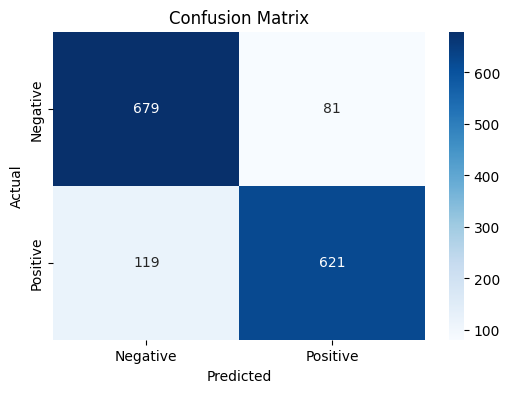

In [14]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [15]:
print("Accuracy on test data:", accuracy_score(y_test, y_pred))


Accuracy on test data: 0.8666666666666667
